### Тема “Перевод с механизмом внимания”

Разобраться с моделькой перевода (с механизмом внимания) как она устроена, запустить для перевода с русского на английский (при желании можно взять другие пары языков)

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

2022-11-28 14:34:35.013116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


!wget http://www.manythings.org/anki/rus-eng.zip

!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/

In [2]:
path_to_file = "rus-eng/rus.txt"

In [3]:
def preprocess_sentence(w):
    w = w.lower().strip()
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
preprocess_sentence("The sentence for test.")

'<start> the sentence for test . <end>'

In [5]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]
    return zip(*word_pairs)

In [6]:
en, ru = create_dataset(path_to_file, None)
print(en[0])
print(ru[0])

<start> go . <end>
<start> марш ! <end>


In [7]:
len(en), len(ru)

(451436, 451436)

In [8]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    targ_lang, inp_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [9]:
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

In [10]:
input_tensor, target_tensor

(array([[   1, 5663,   24, ...,    0,    0,    0],
        [   1,  198,    3, ...,    0,    0,    0],
        [   1,  301,    3, ...,    0,    0,    0],
        ...,
        [   1,   33,  234, ...,    0,    0,    0],
        [   1,   10,  298, ...,    0,    0,    0],
        [   1,   27,   65, ...,    0,    0,    0]], dtype=int32),
 array([[ 1, 27,  3, ...,  0,  0,  0],
        [ 1, 27,  3, ...,  0,  0,  0],
        [ 1, 27,  3, ...,  0,  0,  0],
        ...,
        [ 1, 15,  7, ...,  0,  0,  0],
        [ 1, 15,  7, ...,  0,  0,  0],
        [ 1, 15,  7, ...,  0,  0,  0]], dtype=int32))

In [11]:
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [12]:
max_length_targ, max_length_inp

(11, 15)

In [13]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [14]:
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [15]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
807 ----> поставьте
8 ----> это
428 ----> обратно
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
130 ----> put
18 ----> that
95 ----> back
3 ----> .
2 ----> <end>


In [17]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)

dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

2022-11-28 14:35:00.951468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
example_input_batch, example_target_batch = next(iter(dataset))


In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [20]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [21]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [22]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

In [23]:
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [24]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):

        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [25]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

In [26]:
print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [27]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        # используем слой внимания
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)

        return x, state, attention_weights

In [28]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

In [29]:
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7335)


In [30]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [31]:
@tf.function
def train_step_att(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [32]:
EPOCHS = 30

for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step_att(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6780
Epoch 1 Batch 100 Loss 2.1172
Epoch 1 Batch 200 Loss 1.7381
Epoch 1 Batch 300 Loss 1.7027
Epoch 1 Batch 400 Loss 1.6371
Epoch 1 Batch 500 Loss 1.4349
Epoch 1 Batch 600 Loss 1.3621
Epoch 1 Batch 700 Loss 1.1818
Epoch 1 Batch 800 Loss 1.1806
Epoch 1 Batch 900 Loss 1.0532
Epoch 1 Batch 1000 Loss 1.1090
Epoch 1 Batch 1100 Loss 0.9963
Epoch 1 Batch 1200 Loss 0.9919
Epoch 1 Loss 1.4087
Time taken for 1 epoch 1578.5400807857513 sec

Epoch 2 Batch 0 Loss 0.7618
Epoch 2 Batch 100 Loss 0.7524
Epoch 2 Batch 200 Loss 0.7679
Epoch 2 Batch 300 Loss 0.7569
Epoch 2 Batch 400 Loss 0.6012
Epoch 2 Batch 500 Loss 0.6851
Epoch 2 Batch 600 Loss 0.6592
Epoch 2 Batch 700 Loss 0.5682
Epoch 2 Batch 800 Loss 0.6622
Epoch 2 Batch 900 Loss 0.5055
Epoch 2 Batch 1000 Loss 0.5184
Epoch 2 Batch 1100 Loss 0.5511
Epoch 2 Batch 1200 Loss 0.4225
Epoch 2 Loss 0.6351
Time taken for 1 epoch 1499.1796972751617 sec

Epoch 3 Batch 0 Loss 0.3732
Epoch 3 Batch 100 Loss 0.3413
Epoch 3 Batch 200 Loss 0.3

In [33]:
def evaluate_attention(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot


In [34]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [35]:
def translate_attention(sentence):
    result, sentence, attention_plot = evaluate_attention(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [36]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> сегодня нет дождя . <end>
Predicted translation: it isn't raining today . <end> 


/var/folders/hp/hkxqgbzn6rq8m4_rb6kgzr1c0000gn/T/ipykernel_2449/1344664323.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/hp/hkxqgbzn6rq8m4_rb6kgzr1c0000gn/T/ipykernel_2449/1344664323.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


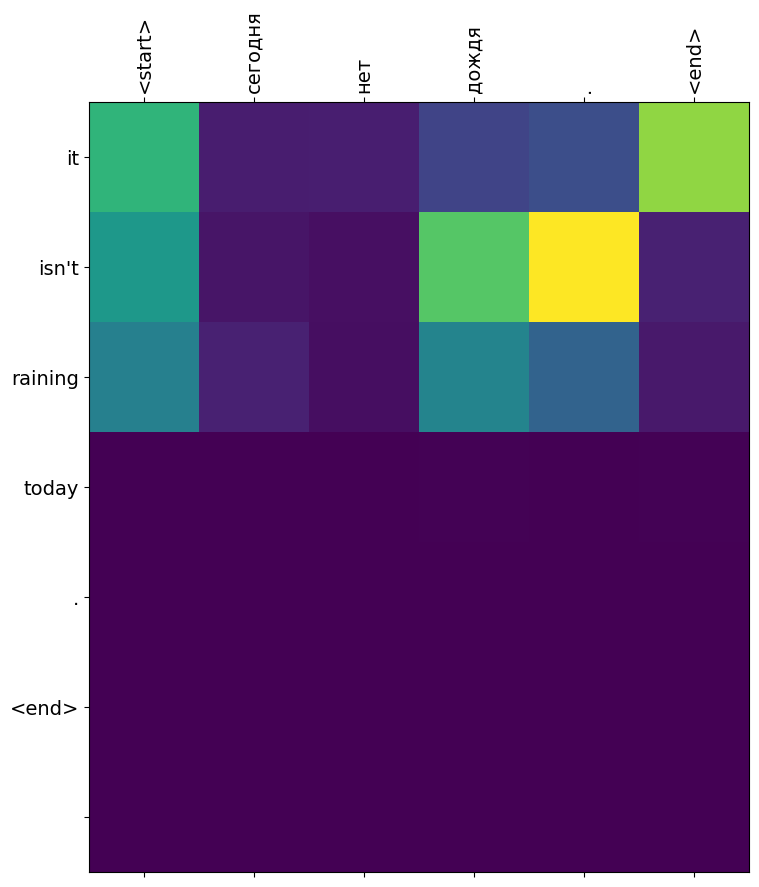

In [37]:
translate_attention('Сегодня нет дождя.')

Input: <start> сегодня нет дождя , светит солнце . <end>
Predicted translation: it's not home today . <end> 


/var/folders/hp/hkxqgbzn6rq8m4_rb6kgzr1c0000gn/T/ipykernel_2449/1344664323.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/hp/hkxqgbzn6rq8m4_rb6kgzr1c0000gn/T/ipykernel_2449/1344664323.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


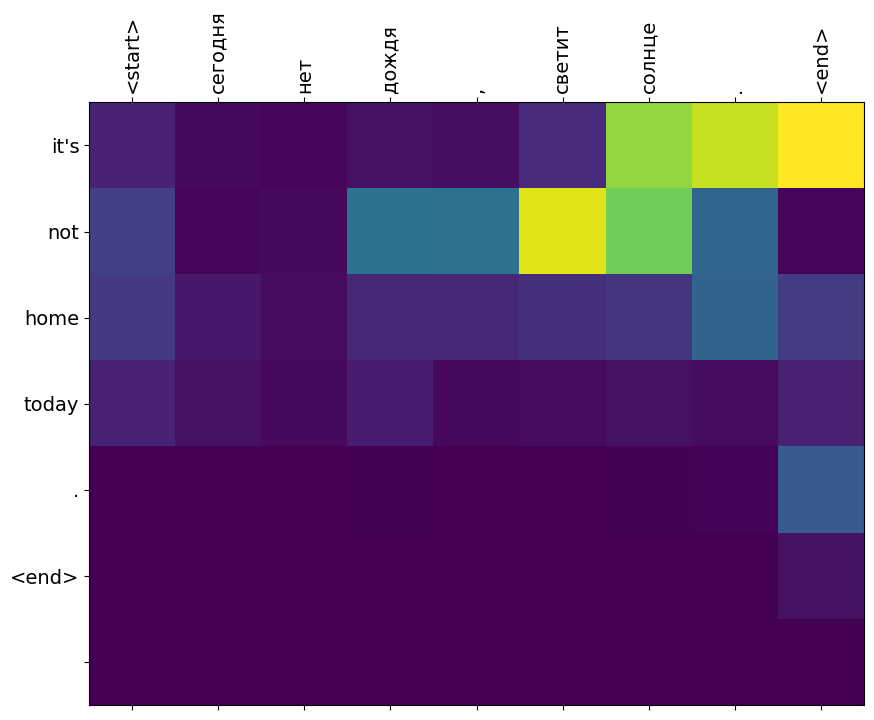

In [38]:
translate_attention('Сегодня нет дождя, светит солнце.')

Input: <start> сегодня нет дождя , светит солнце , но есть маленькие облака . <end>
Predicted translation: it's not worse today is today . <end> 


/var/folders/hp/hkxqgbzn6rq8m4_rb6kgzr1c0000gn/T/ipykernel_2449/1344664323.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/var/folders/hp/hkxqgbzn6rq8m4_rb6kgzr1c0000gn/T/ipykernel_2449/1344664323.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


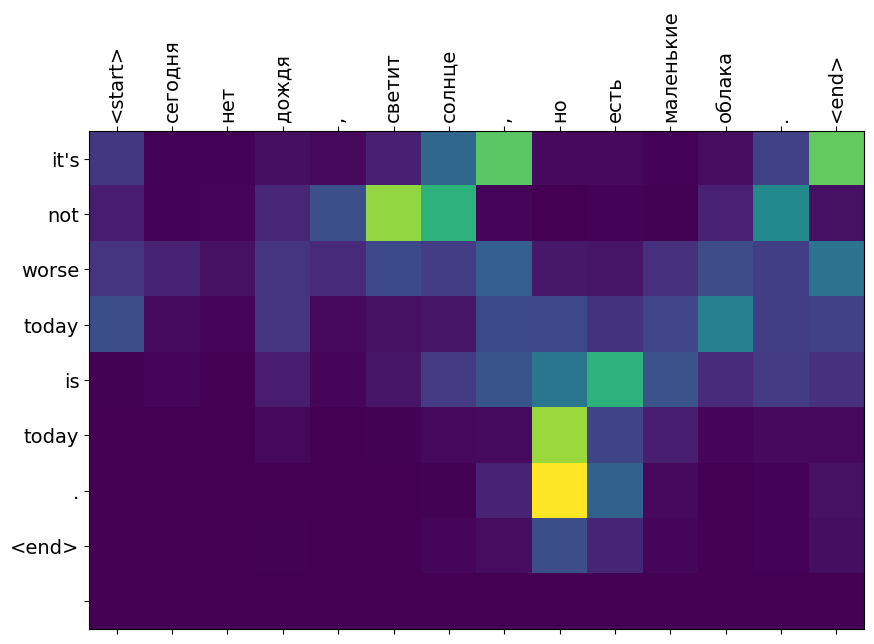

In [39]:
translate_attention('Сегодня нет дождя, светит солнце, но есть маленькие облака.')

В целом модель не показывает конструктивных улучшений качества перевода по сранению с моделью без внимания. Возможно требуется больше обучения